In [1]:
import sys
import os
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

PROJ_ROOT = os.pardir
data_dir = join(PROJ_ROOT, 'data')
#src_dir = join(PROJ_ROOT, 'src')
#sys.path.append(src_dir)

pd.pandas.set_option('display.max_columns', None)

import warnings
warnings.simplefilter(action='ignore')

In [2]:
bank_data = join(PROJ_ROOT, 'data', 'bank-additional-full.csv')
bank_data = pd.read_csv(bank_data, sep=';')

print(bank_data.shape)
bank_data.head()

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
# convert 'unkonwn' to np.nan
bank_data.replace('unknown', np.nan, inplace=True)

# drop duration, should not be used for a predictive model
bank_data.drop('duration', axis=1, inplace=True)

# convert response to 0 & 1's
bank_data['y'].replace({'no': 0, 'yes': 1}, inplace=True)

## Split Dataset

In [4]:
bank_train, bank_val, response_train, response_val = train_test_split(
    bank_data, bank_data['y'], test_size=0.2, random_state=12, stratify=bank_data['y'])

## Plot Target

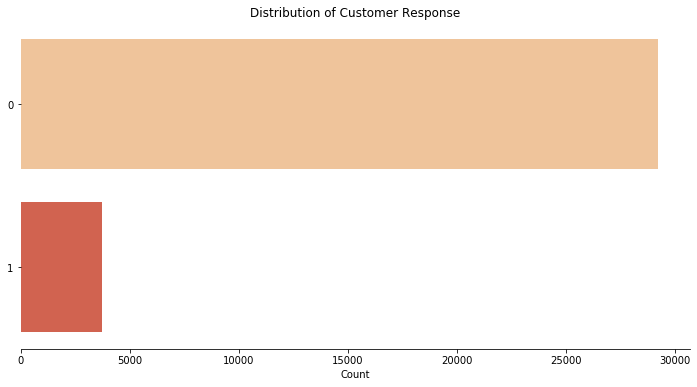

Percentage of each class:
0    0.887344
1    0.112656
Name: y, dtype: float64


In [5]:
def plot_target(df, target):
    '''Creates a simple bar chart of the response variable's value counts'''
    plt.figure(figsize=(12, 6))
    sns.barplot(df[target].value_counts(), 
                df[target].dropna().unique(), 
                palette='OrRd',
                orient='h')
    sns.despine(left=True)
    plt.xlabel('Count')
    plt.title(f'Distribution of Customer Response')
    # plt.savefig('class_imbalance.png')
    plt.show()
    print('Percentage of each class:\n{}'.format(df[target].value_counts() / df.shape[0]))
    
plot_target(bank_train, 'y')

## Missing Values

In [6]:
def feats_with_na_above_thresh(df, min_thresh, max_thresh=1.0):
    missing_feats = [feat for feat in df.columns if 
                     (df[feat].isnull().sum() / df.shape[0]) > min_thresh and
                     df[feat].isnull().sum() / df.shape[0] <= max_thresh]
    return df[missing_feats].isnull().mean().sort_values(ascending=False)

feats_with_na_above_thresh(bank_train, 0)

default      0.210015
education    0.042367
loan         0.024704
housing      0.024704
job          0.007921
marital      0.001760
dtype: float64

When we preprocess, we will remove the instances that have missing values in the *job* and *marital* features.

### Relationship between missing & response variable

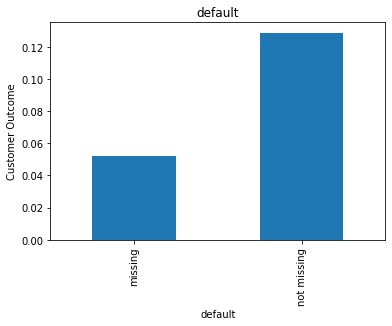

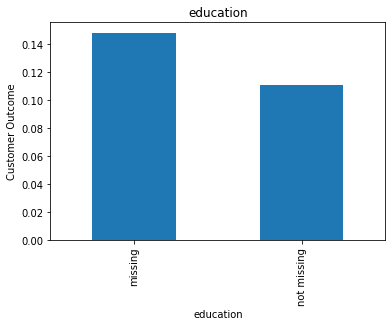

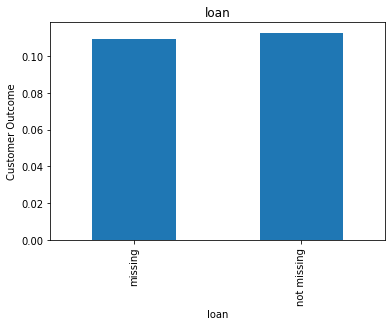

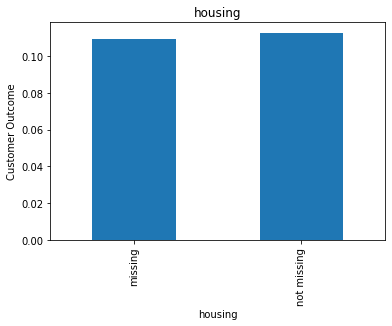

In [7]:
def compare_na_value(df, feat):
    df = df.copy()
    df[feat] = np.where(df[feat].isnull(), 'missing', 'not missing')
    df.groupby(feat)['y'].mean().plot.bar()
    plt.ylabel('Customer Outcome')
    plt.title(feat)
    plt.show()
    
na_feats_gt_2pct = feats_with_na_above_thresh(bank_train, 0.02).index
for feat in na_feats_gt_2pct:
    compare_na_value(bank_train, feat)

It looks like when a customers' default status is unknown, not as likely to purchase a bank product - that could be a valuable piece of information.

## Numerical variables

In [8]:
num_feats = [feat for feat in bank_train.columns if 
    bank_train[feat].dtypes != 'O']

print(f'Number of numerical variables: {len(num_feats)}')

Number of numerical variables: 10


### Discreate variables

In [9]:
discrete_feats = [feat for feat in num_feats if len(
    bank_train[feat].unique()) < 30 and feat not in ['y']]

print(f'Number of discrete variables: {len(discrete_feats)}')
bank_train[discrete_feats].head()

Number of discrete variables: 6


,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed
21776,999,0,1.4,93.444,-36.1,5228.1
32837,999,1,-1.8,92.893,-46.2,5099.1
38523,999,0,-3.4,92.431,-26.9,5017.5
36250,999,1,-2.9,92.963,-40.8,5076.2
20976,999,0,1.4,93.444,-36.1,5228.1


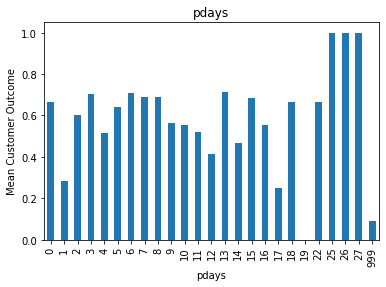

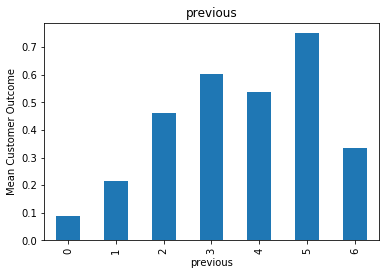

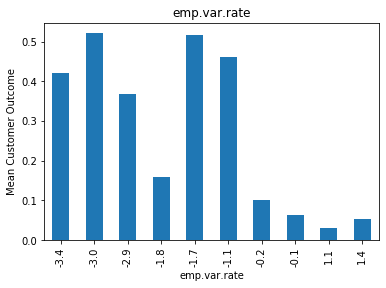

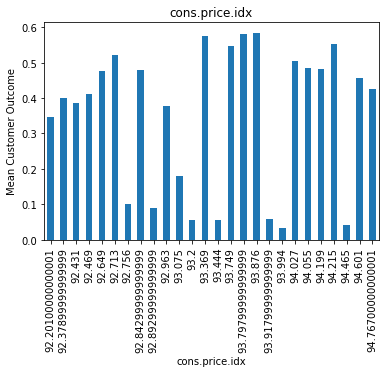

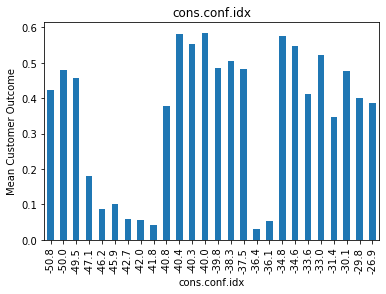

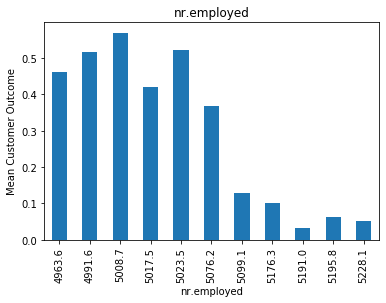

In [10]:
def outcome_to_discrete(df, feat):
    df = df.copy()
    df.groupby(feat)['y'].mean().plot.bar()
    plt.title(feat)
    plt.ylabel('Mean Customer Outcome')
    plt.show()
    
for feat in discrete_feats:
    outcome_to_discrete(bank_train, feat)

If a customer has note been contacted before (*pdays* = 999), much less likely to purchase a product. We will engineer this feature at a later time.

### Continuous Variables

In [11]:
cont_feats = [feat for feat in num_feats if feat not in discrete_feats and feat not in ['y']]

print(f'Number of continuous features: {len(cont_feats)}')

Number of continuous features: 3


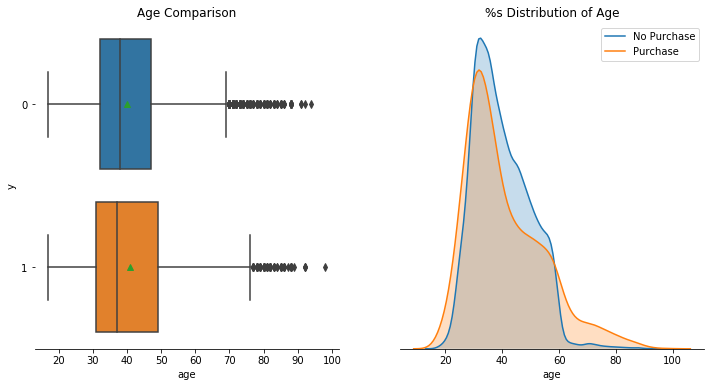

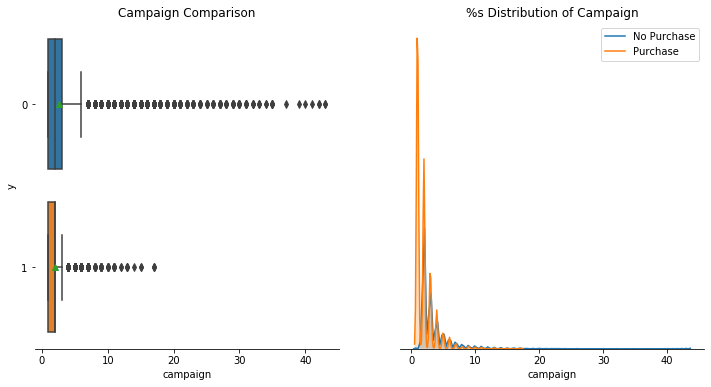

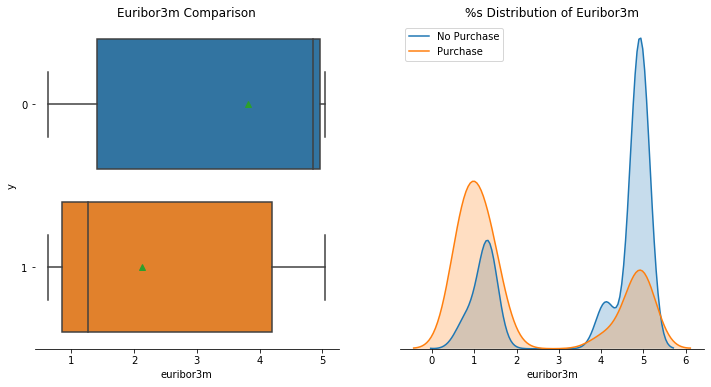

In [12]:
def plot_continuous_feats(df, col, tgt, label=None):    
    df = df.copy()
    majority_df = df.loc[df[tgt] == 0]
    minority_df = df.loc[df[tgt] == 1]
    fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
    box = sns.boxplot(x=df[col], y=df[tgt], orient='h', showmeans=True, ax=axs[0])
    label = label
    sns.kdeplot(majority_df[col], shade=True, label=label[0], ax=axs[1])
    kde = sns.kdeplot(minority_df[col], shade=True, label=label[1], ax=axs[1])
    kde.legend(labels=label, loc=0)
    sns.despine(left=True)
    kde.set(xlabel=col, ylabel='', yticks=([]), title=f'%s Distribution of {str.capitalize(col)}')
    box.set(xlabel=col, ylabel=tgt, title=f'{str.capitalize(col)} Comparison')
    plt.show()

for feat in cont_feats:
    plot_continuous_feats(bank_train, feat, 'y', label=['No Purchase', 'Purchase'])

## Categorical Features

In [13]:
cat_feats = [feat for feat in bank_train.columns if bank_train[feat].dtypes == 'O']

print(f'Number of categorical features: {len(cat_feats)}')

Number of categorical features: 10


In [14]:
# observe cardinality
bank_train[cat_feats].nunique().sort_values(ascending=False)

job            11
month          10
education       7
day_of_week     5
poutcome        3
marital         3
contact         2
loan            2
housing         2
default         2
dtype: int64

### Rare Labels

We will observe if any of the nominal features have labels that are only present in a small number of instances.

In [15]:
def observe_rare_labels(df, feat, tgt, rare_thresh):
    df = df.copy()
    cat_perc = df.groupby(feat)[tgt].count() / df.shape[0]
    return cat_perc[cat_perc < rare_thresh]

# print categories of features that are present in less than 1% of instances
for feat in cat_feats:
    print(observe_rare_labels(bank_train, feat, 'y', rare_thresh=0.01))
    print()

Series([], Name: y, dtype: float64)

Series([], Name: y, dtype: float64)

education
illiterate    0.000425
Name: y, dtype: float64

default
yes    0.000091
Name: y, dtype: float64

Series([], Name: y, dtype: float64)

Series([], Name: y, dtype: float64)

Series([], Name: y, dtype: float64)

month
dec    0.004552
Name: y, dtype: float64

Series([], Name: y, dtype: float64)

Series([], Name: y, dtype: float64)



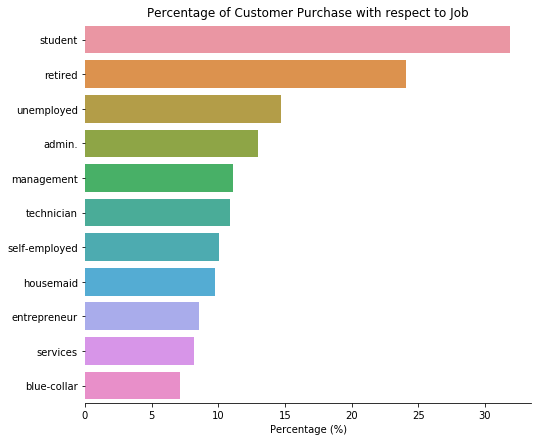

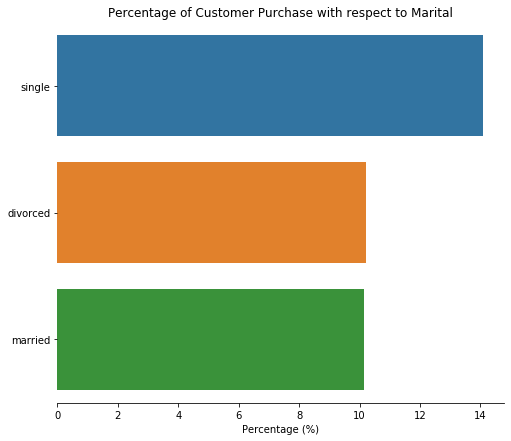

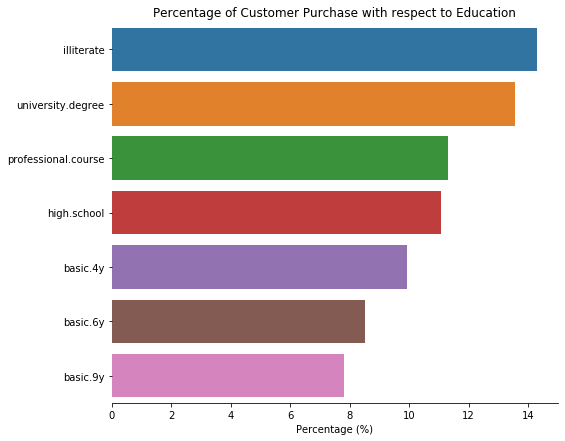

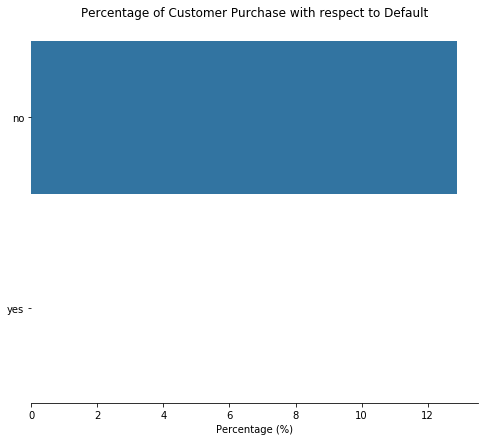

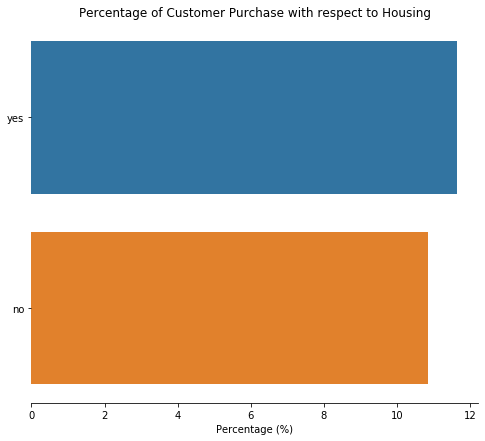

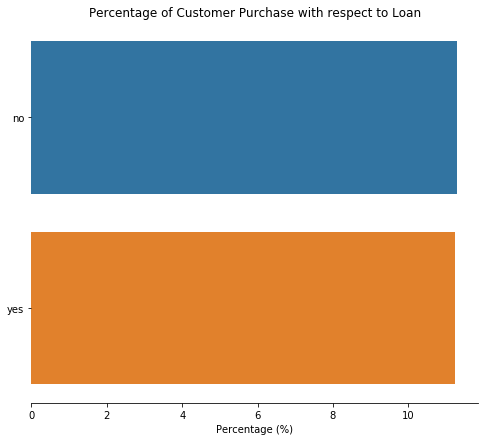

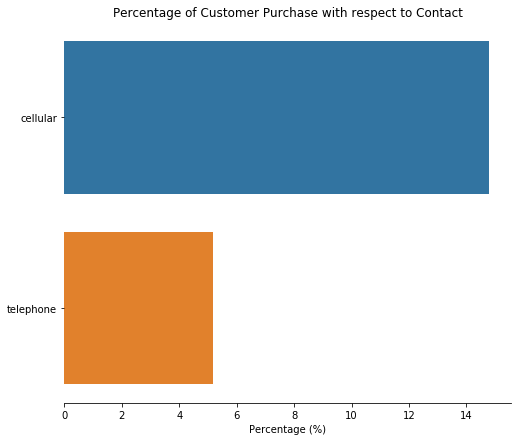

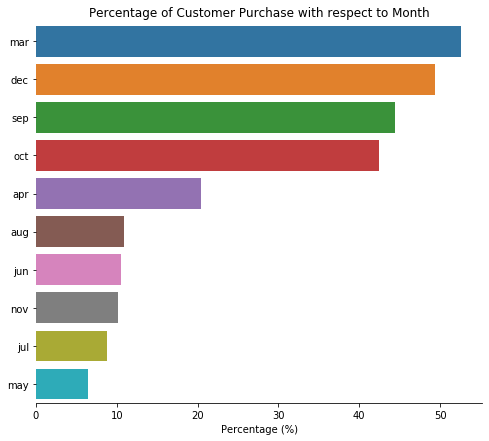

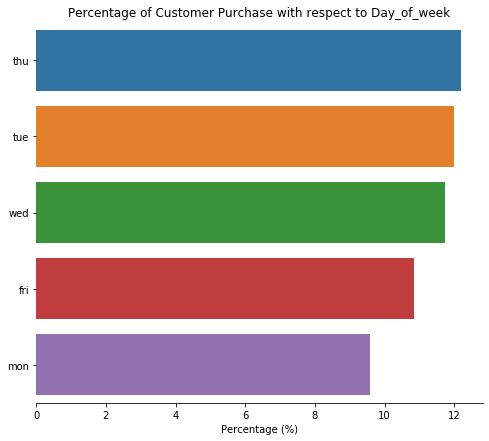

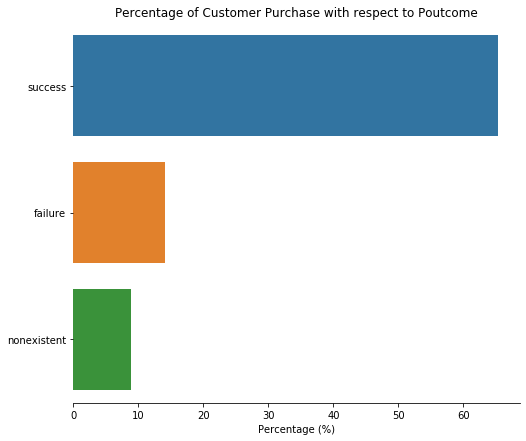

In [16]:
def cat_mean(df, col, tgt):
    return (df.groupby(col)[tgt].mean()).sort_values(ascending=False)

def plot_cat_feats(df, col, tgt):
    plt.figure(figsize=(8, 7))
    sns.barplot(x=(round(cat_mean(df, col, tgt), 4) * 100).values, 
                y=cat_mean(df, col, tgt).index, orient='h')
    sns.despine(left=True)
    plt.xlabel('Percentage (%)')
    plt.ylabel('')
    plt.title(f'Percentage of Customer Purchase with respect to {str.capitalize(col)}')
    plt.show()

for feat in cat_feats:
    plot_cat_feats(bank_train, feat, 'y')

We are confident *loan* is not a predictive feature, and a *housing* loan does not provide much signal either.